In [ ]:
!pip install transformers

In [2]:
import torch
import torch.nn as nn

In [3]:
import os
os.chdir('/content/drive/MyDrive/Text Classification')

In [ ]:
#! unzip archive\ \(1\).zip

In [4]:
! ls

'Copy of Copy of data.ipynb'   Corona_NLP_train.csv   LSTM.ipynb
 Corona_NLP_test.csv	       data.ipynb


In [5]:
import chardet
with open('Corona_NLP_test.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [6]:
import pandas as pd


In [7]:
train_data=pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1')
test_data=pd.read_csv('Corona_NLP_test.csv')

In [8]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
len(train_data)

41157

In [12]:
train_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


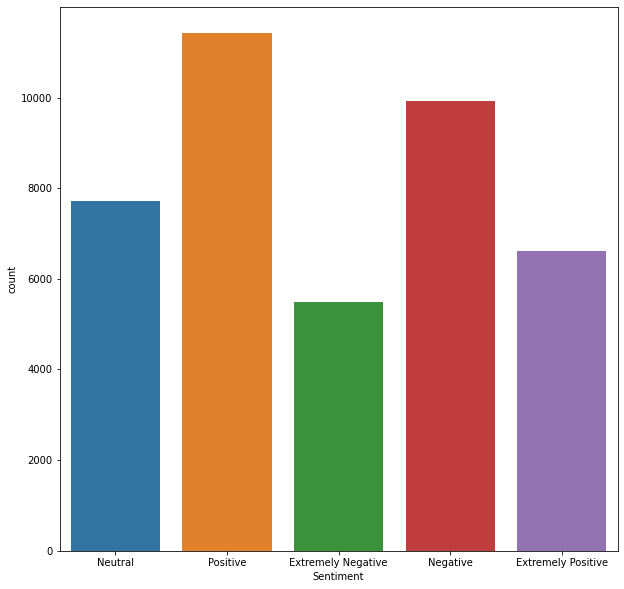

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(train_data.Sentiment)

In [14]:
lable_dict={}
for i in train_data.Sentiment:
  if i not in lable_dict:
    lable_dict[i]=len(lable_dict)


In [15]:
lable_dict

{'Extremely Negative': 2,
 'Extremely Positive': 4,
 'Negative': 3,
 'Neutral': 0,
 'Positive': 1}

In [33]:
from transformers import RobertaTokenizer,RobertaModel

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def token_counter(text, tokenizer):
    return len(tokenizer.encode(text))

tok_len = train_data["OriginalTweet"].apply(lambda x : token_counter(x, tokenizer))

max(list(tok_len))

KeyboardInterrupt: ignored

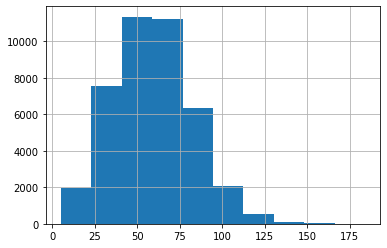

count    41157.000000
mean        58.824307
std         23.142010
min          5.000000
25%         42.000000
50%         58.000000
75%         74.000000
max        184.000000
Name: OriginalTweet, dtype: float64

In [17]:
pd.Series(tok_len).hist()
plt.show()
pd.Series(tok_len).describe()

In [18]:
sen_len=90
num_lables=5

In [19]:
tokenizer.model_max_length=sen_len

In [20]:
import re

def remove_links(text):
    to_remove = ['\r','\n',',',';',':','.']
    
    out = re.sub(r'http\S+', '', text)
    
    for token in to_remove:
        out = out.replace(token, '')
    
    return re.sub(' +', ' ', out.lower()) #Remove duplicate spaces


name_to_idx = {
    "Extremely Negative" : 0,
    "Negative" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Extremely Positive" : 4
}

def process_tgt(value):
    return name_to_idx[value]

In [21]:
import random
example=random.choice(train_data['OriginalTweet'].to_list())
print("EXAMPLE:\n",example)
print("\nPRE-PROCESSED:\n",remove_links(example))
print("\nTOKENIZED\n",remove_links(example))

EXAMPLE:
 WeÂve just added Gift Cards to our online shop. So, you can still spoil your friends and family during the #covid_19 lockdown or gift Âfuture youÂ with a shopping spree.?Head over to our online store via the link inÂ https://t.co/tx6VpGHxPp

PRE-PROCESSED:
 weâve just added gift cards to our online shop so you can still spoil your friends and family during the #covid_19 lockdown or gift âfuture youâ with a shopping spree?head over to our online store via the link inâ 

TOKENIZED
 weâve just added gift cards to our online shop so you can still spoil your friends and family during the #covid_19 lockdown or gift âfuture youâ with a shopping spree?head over to our online store via the link inâ 


In [23]:
train_text = list(train_data["OriginalTweet"].apply(remove_links))
train_labels = list(train_data["Sentiment"].apply(process_tgt))

test_text = list(test_data["OriginalTweet"].apply(remove_links))
test_labels = list(test_data["Sentiment"].apply(process_tgt))

In [24]:
print("Train data ",len(train_text))
print("Test data ",len(test_text))

Train data  41157
Test data  3798


In [38]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    
    def __init__(self, text,tokenizer, labels):
        super().__init__()
        self.tokenizer=tokenizer
        self.text = text
        self.labels = labels
        
        
    def __getitem__(self, idx):
        text = str(self.text[idx])
        text = ' '.join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True, 
             padding='max_length',
            truncation='only_first',
            return_token_type_ids = True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids'  : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
        },torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)

train_dataset = CreateDataset(train_text,tokenizer, train_labels)
test_dataset = CreateDataset(test_text,tokenizer, test_labels)

In [39]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [40]:
for i,exp in enumerate(train_loader):
  print(exp)
  break

[{'ids': tensor([[    0,  1039,  2262,  ...,     1,     1,     1],
        [    0,   625, 36237,  ...,     1,     1,     1],
        [    0,  7215,   261,  ...,     1,     1,     1],
        ...,
        [    0,  1039,   406,  ...,     1,     1,     1],
        [    0,  8585,    16,  ...,     1,     1,     1],
        [    0,   108, 11616,  ...,     1,     1,     1]]), 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}, tensor([2, 3, 3, 3, 0, 3, 3, 2, 3, 1, 2, 4, 4, 3, 3, 3, 2, 2, 4, 3, 0, 2, 4, 4,
        1, 4, 1, 0, 1, 0, 1, 4])]


In [43]:
class Roberta_Model(nn.Module):
  
  def __init__(self):
    super(Roberta_Model, self).__init__()
    self.l1 = RobertaModel.from_pretrained('roberta-base') 
    self.pre_classifier = nn.Linear(768, 768)
    self.dropout = nn.Dropout(0.3)
    self.classifier = nn.Linear(768, 5)
  
  def forward(self,input_ids, attention_mask, token_type_ids):
    x = self.l1(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
    hidden_state = x[0]
    pooler = hidden_state[:,0]
    pooler = self.pre_classifier(pooler)
    pooler = nn.ReLU()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return output
    
model = Roberta_Model()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for i,exp in enumerate(train_loader):
  exp=exp[0]
  print(exp)
  out=model(exp['ids'],exp['mask'],exp['token_type_ids'])
  print(out.shape)
  break

{'ids': tensor([[    0,  1039,  2262,  ...,     1,     1,     1],
        [    0,   625, 36237,  ...,     1,     1,     1],
        [    0,  7215,   261,  ...,     1,     1,     1],
        ...,
        [    0,  1039,   406,  ...,     1,     1,     1],
        [    0,  8585,    16,  ...,     1,     1,     1],
        [    0,   108, 11616,  ...,     1,     1,     1]]), 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}


In [ ]:
from tqdm import tqdm

class Trainer():
    
    def __init__(self, model, train_loader, valid_loader):
        
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def train_epoch(self, f_loss, optimizer, device):

        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.train()

        correct = 0
        tot_loss = 0
        N = 41157 # Dataset length

        # iterator = tqdm(enumerate(self.train_loader))
        iterator = enumerate(self.train_loader)

        for i, (inputs, targets) in iterator:
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass through the network up to the loss
            outputs = self.model(inputs['ids'],inputs['mask'],inputs['token_type_ids'])

            loss = f_loss(outputs, targets)

            loss_value = loss.item()

            # Backward and optimize

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tot_loss += inputs.shape[0] * loss_value

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

            #iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def valid_epoch(self, f_loss, device):
        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.eval()

        correct = 0
        tot_loss = 0
        N = 3798 # Dataset length

        # iterator = tqdm(enumerate(self.valid_loader))
        iterator = enumerate(self.valid_loader)

        with torch.no_grad():
            for i, (inputs, targets) in iterator:
                inputs, targets = inputs.to(device), targets.to(device)

                # Compute the forward pass through the network up to the loss
                outputs = self.model(inputs['ids'],inputs['mask'],inputs['token_type_ids'])

                loss = f_loss(outputs, targets)

                tot_loss += inputs.shape[0] * loss.item()

                predicted_targets = outputs.argmax(dim=1)
                correct += (predicted_targets == targets).sum().item()

                # iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def training(self, f_loss, optimizer, device, epochs = 10):

        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []

        for i in range(epochs):
            print("EPOCH {}/{}".format(i + 1, epochs))
            train_results = self.train_epoch(f_loss, optimizer, device)
            print("Training loss : {: .3f} | Training accuracy : {: .3f}".format(*train_results))
            valid_results = self.valid_epoch(f_loss, device)
            print("Validation loss : {: .3f} | Validation accuracy : {: .3f}\n".format(*valid_results))

            train_loss.append(train_results[0])
            train_acc.append(train_results[1])
            valid_loss.append(valid_results[0])
            valid_acc.append(valid_results[1])

        return train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

f_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
trainer = Trainer(model, train_loader, test_loader)

In [ ]:
train_loss, train_acc, valid_loss, valid_acc = trainer.training(f_loss, optimizer, device, epochs = 8)

EPOCH 1/8
Training loss :  2.132 | Training accuracy :  0.279
Validation loss :  1.598 | Validation accuracy :  0.302

EPOCH 2/8
Training loss :  1.405 | Training accuracy :  0.411
Validation loss :  1.678 | Validation accuracy :  0.345

EPOCH 3/8
Training loss :  1.032 | Training accuracy :  0.582
Validation loss :  1.969 | Validation accuracy :  0.376

EPOCH 4/8
Training loss :  0.690 | Training accuracy :  0.735
Validation loss :  2.378 | Validation accuracy :  0.402

EPOCH 5/8
Training loss :  0.514 | Training accuracy :  0.815
Validation loss :  2.855 | Validation accuracy :  0.422

EPOCH 6/8
Training loss :  0.385 | Training accuracy :  0.872
Validation loss :  3.844 | Validation accuracy :  0.415

EPOCH 7/8
Training loss :  0.333 | Training accuracy :  0.896
Validation loss :  3.883 | Validation accuracy :  0.428

EPOCH 8/8
Training loss :  0.258 | Training accuracy :  0.921
Validation loss :  4.704 | Validation accuracy :  0.416

